In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

from collections import Counter
import re

In [2]:
############# Sei

sei_supp_table_1 = pd.read_excel('../data/Sei/41588_2022_1102_MOESM3_ESM.xlsx', sheet_name='Supp Table 1', skiprows=1)
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135
...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386
21904,WI-38 | CTCF | ENCODE,0.997,0.686
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385


In [3]:
sei_supp_table_1[['cell_name', 'assay', 'source', 'part']] = (
    sei_supp_table_1['Chromatin Profile']
    .str.split(r"\s*\|\s*", n=3, expand=True)
)
sei_supp_table_1['index'] = sei_supp_table_1.index
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC,cell_name,assay,source,part,index
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033,HeLa_Epithelium_Cervix,BTAF1,ID:1,None,0
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,None,1
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,None,2
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,None,3
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,None,4
...,...,...,...,...,...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665,WERI-Rb-1,CTCF,ENCODE,None,21902
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386,WERI-Rb-1,DNase,ENCODE,None,21903
21904,WI-38 | CTCF | ENCODE,0.997,0.686,WI-38,CTCF,ENCODE,None,21904
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385,WI-38 (4OHTAM_20nM_72hr),DNase,ENCODE,None,21905


In [4]:
sei_supp_table_2 = pd.read_excel('../data/Sei/41588_2022_1102_MOESM3_ESM.xlsx', sheet_name='Supp Table 2', skiprows=1)
sei_supp_table_2

,Original Cell Type Name,Standardized Celltype Name
0,1015c,1015c
1,10326,10326
2,1184_Stem_cell,1184_Stem_cell
3,133_Astrocyte,133_Astrocyte
4,143B_Osteosarcoma_cell,143B_Osteosarcoma_cell
...,...,...
1691,ZR-75-1_Breast,ZR-75-1
1692,ZR-75-1_Embryonic_Stem_Cell_Breast,ZR-75-1
1693,ZR-75-1_Epithelium_Mammary_Gland,ZR-75-1
1694,ZR-75-30,ZR-75-30_Epithelium_Mammary_Gland


In [5]:
cell_name_map_dict = sei_supp_table_2.set_index('Original Cell Type Name')['Standardized Celltype Name'].to_dict()
cell_name_map_dict

{'1015c': '1015c',
 '10326': '10326',
 '1184_Stem_cell': '1184_Stem_cell',
 '133_Astrocyte': '133_Astrocyte',
 '143B_Osteosarcoma_cell': '143B_Osteosarcoma_cell',
 '21NT_Epithelium_Breast': '21NT_Epithelium_Breast',
 '226LDM': '226LDM',
 '22RV1_Epithelium_Prostate': '22RV1',
 '293FT_Embryonic_Kidney': '293FT',
 '293T': '293T',
 '293T_Embryonic_Kidney': '293T',
 '293T-Rex': '293T-Rex',
 '3565_cells': '3565_cells',
 '451Lu_Melanoma_Cell': '451Lu_Melanoma_Cell',
 '4star': '4star',
 '501-Mel_melanoma': '501-Mel',
 '501-Mel_Melanoma_Cell': '501-Mel',
 '5637_Stem_cell': '5637_Stem_cell',
 '5637_Urinary_Bladder': '5637_Urinary_Bladder',
 '6540_cells_Epithelium': '6540_cells_Epithelium',
 '697_B-ALL': '697_B-ALL',
 '7250_Fibroblast': '7250_Fibroblast',
 '76NF2V_Breast': '76NF2V_Breast',
 '786-0_Kidney': '786-0_Kidney',
 '786-O_Epithelium_Kidney': '786-O_Epithelium_Kidney',
 '8988T': '8988T',
 '8988t_Epithelium_Pancreas': '8988T',
 '9.4_Neuron_Prefrontal': '9.4_Neuron_Prefrontal',
 '90-8TL_Schw

In [6]:
sei_supp_table_1['cell_type'] = sei_supp_table_1['cell_name'].map(cell_name_map_dict)
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC,cell_name,assay,source,part,index,cell_type
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033,HeLa_Epithelium_Cervix,BTAF1,ID:1,None,0,HeLa_Cervical_Carcinoma
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,None,1,H9_Embryonic_Stem_Cell_Embryo
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,None,2,H9_Embryonic_Stem_Cell_Embryo
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,None,3,H9_Embryonic_Stem_Cell_Embryo
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,None,4,H9_Embryonic_Stem_Cell_Embryo
...,...,...,...,...,...,...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665,WERI-Rb-1,CTCF,ENCODE,None,21902,WERI-Rb-1_Eye
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386,WERI-Rb-1,DNase,ENCODE,None,21903,WERI-Rb-1_Eye
21904,WI-38 | CTCF | ENCODE,0.997,0.686,WI-38,CTCF,ENCODE,None,21904,WI-38_Fibroblast_Lung
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385,WI-38 (4OHTAM_20nM_72hr),DNase,ENCODE,None,21905,NaN


In [7]:
sei_supp_table_1.to_csv('../data/Sei/Sei_tracks_info.csv', index=False)

In [8]:
df_pivot = sei_supp_table_1.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)

df_pivot

assay                    ADNP AEBP2 AFF1 AFF4 AGO1 AGO2  AHR AHRR AP-2alpha AP-2gamma APOBEC3B   AR ARID1A ARID2 ARID3A ARID5B ARNT ARNT2 ARNTL ARRB1 ASCL1 ASCL2 ASH1L ASH2L ASXL1 ATAC-seq ATF1 ATF2 ATF3 ATF4 ATF5 ATF7IP ATOH1 ATRX AUTS2 BACH1 BACH2 BAF155 BAF170 BAHD1 BANF1 BANP BARX1 BARX2 BATF BATF3 BCAT1 BCL11A BCL11B BCL3 BCL6 BCLAF1 BCOR BDP1 BHLHE40 BIRA BMI1 BPTF BRAF BRCA1 BRD1 BRD2    BRD3    BRD4 BRD7 BRD9 BRDU BRF1 BRF2 BRPF3 BTAF1 Bach1 Brg1 C11orf30 C17orf49 C17orf96 CAMTA2 CASP8AP2 CBFA2T2 CBFB CBX1 CBX2 CBX3 CBX4 CBX5 CBX6 CBX7 CBX8 CCDC101 CCND2 CCNT2 CD59 CD74 CDC5L CDCA2 CDK12 CDK2 CDK6 CDK7 CDK8 CDK9 CDX2 CEBPA CEBPB CEBPD CEBPG CEBPZ CENPA CENPC CENPT CHAMP1 CHAT CHD1 CHD2 CHD4 CHD5 CHD7 CHD8 CHRM2 CIITA CLOCK CNOT3 COPS2 COREST CPSF3L CREB1 CREB3 CREB3L4 CREBBP CREM CRY1 CSDE1 CSNK2A1 CTBP1 CTBP2 CTCF CTCFL CTNNB1 CUX1 CtBP2 DACOR1 DAXX DCP1A DDX20 DDX21 DDX5 DEAF1  DEK DIDO1 DLX1 DLX2 DMC1 DNMT1 DNMT3A DNMT3B    DNase DNase.all.peaks DNase.fdr0.01.hot  \
cell_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1015c                     NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN      NaN  NaN    NaN   NaN    NaN    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN    NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN     NaN  [8996]  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN      NaN      NaN      NaN    NaN      NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN     NaN    NaN  NaN  NaN   NaN     NaN   NaN   NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN    NaN    NaN      NaN             NaN               NaN   
10326                     NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN      NaN  NaN    NaN   NaN    NaN    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN    NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  [8997]     NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN      NaN      NaN      NaN    NaN      NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN     NaN    NaN  NaN  NaN   NaN     NaN   NaN   NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN    NaN    NaN      NaN             NaN               NaN   
1184_Stem_cell            NaN   

In [9]:
df_avail = df_pivot[['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']]
df_avail = df_avail[(df_avail.isna().sum(axis=1) == 0)]
df_avail

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
A549,"[3147, 4493, 4494, 19920]","[1664, 1668, 2466, 2470, 2613, 2621, 2623, 471...","[2478, 2487, 4707, 4715, 10889, 10890, 10891, ...","[4704, 4706, 5075, 5076, 5081, 5083, 5563, 557..."
AG04450_Fibroblast_Fetal_Lung,"[4497, 19983]",[4724],[4725],"[5088, 5089, 19982]"
Astrocyte_Brain,"[3235, 4651, 4652]",[4991],[4993],[4986]
BE2-C,"[4506, 4507, 20000]","[4730, 9964, 18290]","[9233, 9238, 10592, 10593, 10632]","[5098, 5099, 19999]"
BJ_Fibroblast_Foreskin,"[4508, 4509, 7138, 10659, 10660, 10684, 10685,...","[4733, 14000, 14003, 14005, 14279]","[7961, 10582, 17690]","[5100, 5101, 20001]"
B_Lymphocyte_Blood,"[635, 3146, 4516, 4517]","[919, 4740, 4742, 7037]","[2052, 4281, 4282, 4741, 7637, 7638]",[4737]
Brain,"[10678, 10679, 10680, 16416]","[2324, 2325, 2327, 2443, 9384, 9388, 9391, 939...","[2205, 9371, 9372, 9373, 9374, 9375, 9376, 937...","[5104, 5519]"
Caco-2_Epithelium_Colon,"[4514, 4515, 16625, 20080]",[4735],[17327],"[5102, 5103, 20079]"
Embryonic_Stem_Cell_Embryo,[3016],"[1705, 2210, 4098, 4102, 4106, 6849, 6850, 6983]","[2204, 2212, 4099, 4103, 4107, 9947, 9948, 995...","[9949, 9950, 9957, 9958]"


In [10]:
print(len(df_avail))

61


In [12]:
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

cell_types = ['K562', 'THP-1', 'Jurkat']
cell_types_standard_names = ['K562_Leukemia_Cell', 'Jurkat_T_Lymphocyte_Blood', 'THP-1']

df_Sei_Siraj = df_pivot.loc[cell_types_standard_names][assays]
df_Sei_Siraj.map(lambda x: len(x) if isinstance(x, list) else 0)

assay,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
cell_type,,,,,,,,
K562_Leukemia_Cell,58,91,51,34,11,5,29,29
Jurkat_T_Lymphocyte_Blood,3,18,9,8,2,2,1,2
THP-1,0,2,5,0,0,0,2,5


In [15]:
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

cell_types = ['K562', 'HepG2', 'HEK293T', 'HeLa']
cell_types_standard_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'HEK293T_Epithelium_Embryonic_Kidney', 'HeLa_Cervical_Carcinoma']


In [16]:
df_Sei_Siraj = df_pivot.loc[cell_types_standard_names][assays]
df_Sei_Siraj.map(lambda x: len(x) if isinstance(x, list) else 0)

assay,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
cell_type,,,,,,,,
K562_Leukemia_Cell,58,91,51,34,11,5,29,29
HepG2_Hepatocellular_Carcinoma,9,8,9,2,4,3,2,17
HEK293T_Epithelium_Embryonic_Kidney,1,10,1,1,1,1,0,0
HeLa_Cervical_Carcinoma,2,32,14,2,3,5,10,6


In [23]:
####### CAGI_MPRA

pred_array = load_h5('outputs/CAGI5_MPRA_Sei_pred.h5')
print(pred_array.shape)

(44643, 21907)


In [24]:
MPRA_df = pd.read_csv('../data/CAGI5_MPRA/CAGI5_MPRA.csv')

print(MPRA_df.shape)

(44643, 9)


In [25]:
match_cell_type_dict = {
    'HepG2': 'HepG2',
    'HEK293T': 'HEK293',
    'HEL 92.1.7': 'K562',
    'K562': 'K562',
    'HeLa': 'HeLa'
}

In [26]:
MPRA_df['match_cell_type'] = MPRA_df['cell_type'].map(match_cell_type_dict)
MPRA_df

,chr,pos,ref,alt,value,p-value,element,cell_type,seq,match_cell_type
0,2,60722075,C,-,-0.340,0.005,BCL11A,HEL 92.1.7,CTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGATG...,K562
1,2,60722075,C,A,-0.050,0.389,BCL11A,HEL 92.1.7,ACTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562
2,2,60722075,C,G,-0.130,0.137,BCL11A,HEL 92.1.7,GCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562
3,2,60722075,C,T,-0.700,0.000,BCL11A,HEL 92.1.7,TCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562
4,2,60722076,C,A,-0.080,0.004,BCL11A,HEL 92.1.7,CATAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562
...,...,...,...,...,...,...,...,...,...,...
44638,7,156584296,G,T,0.100,0.000,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN
44639,7,156584297,C,-,0.040,0.112,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN
44640,7,156584297,C,A,-0.170,0.334,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN
44641,7,156584297,C,G,0.060,0.091,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN


In [38]:
for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_Sei_Siraj.loc[cell_types_standard_names[i], assay]
        if isinstance(indice, list) and len(indice) > 0:
            pred_feature = logit(pred_array[:, indice]).mean(1)
            MPRA_df[f'{cell_type}_{assay}'] = pred_feature
        else:
            MPRA_df[f'{cell_type}_{assay}'] = np.nan

In [39]:
MPRA_df

,chr,pos,ref,alt,value,p-value,element,cell_type,seq,match_cell_type,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_H3K27me3,HEK293T_H3K4me1,HEK293T_H3K36me3,HeLa_DNase,HeLa_H3K4me3,HeLa_H3K27ac,HeLa_H3K27me3,HeLa_H3K4me1,HeLa_H3K36me3,HeLa_H3K9me3,HeLa_CTCF,HEK293T_H3K9me3,HEK293T_CTCF
0,2,60722075,C,-,-0.340,0.005,BCL11A,HEL 92.1.7,CTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGATG...,K562,-5.041,-6.965,-7.180,-7.310,-4.179,-10.343,-5.980,-8.417,-3.892,-4.612,-6.102,-5.681,-2.835,-9.413,-3.776,-7.242,-9.448,-7.954,-6.007,-7.912,-6.957,-7.165,-3.260,-9.210,-8.366,-5.403,-4.787,-10.231,-5.988,-8.749,NaN,NaN
1,2,60722075,C,A,-0.050,0.389,BCL11A,HEL 92.1.7,ACTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-5.586,-7.429,-7.603,-7.327,-4.644,-10.318,-6.012,-8.598,-3.875,-4.750,-6.242,-5.718,-3.071,-9.367,-3.986,-7.345,-9.306,-8.099,-6.129,-7.956,-7.186,-7.204,-3.210,-9.075,-8.247,-5.354,-4.680,-10.094,-6.080,-8.720,NaN,NaN
2,2,60722075,C,G,-0.130,0.137,BCL11A,HEL 92.1.7,GCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-5.560,-7.402,-7.600,-7.306,-4.627,-10.307,-6.018,-8.565,-3.854,-4.731,-6.246,-5.681,-3.052,-9.343,-3.994,-7.304,-9.293,-8.084,-6.115,-7.964,-7.156,-7.217,-3.251,-9.080,-8.291,-5.327,-4.700,-10.089,-6.093,-8.693,NaN,NaN
3,2,60722075,C,T,-0.700,0.000,BCL11A,HEL 92.1.7,TCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-5.612,-7.480,-7.628,-7.325,-4.673,-10.322,-6.031,-8.612,-3.909,-4.832,-6.296,-5.745,-3.085,-9.366,-3.955,-7.364,-9.291,-8.140,-6.142,-7.933,-7.183,-7.257,-3.273,-9.135,-8.281,-5.342,-4.708,-10.096,-6.074,-8.713,NaN,NaN
4,2,60722076,C,A,-0.080,0.004,BCL11A,HEL 92.1.7,CATAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-5.658,-7.506,-7.667,-7.359,-4.688,-10.353,-6.026,-8.677,-3.946,-4.851,-6.350,-5.770,-3.111,-9.390,-3.940,-7.438,-9.369,-8.178,-6.201,-7.998,-7.230,-7.271,-3.348,-9.196,-8.348,-5.358,-4.763,-10.137,-6.066,-8.822,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44638,7,156584296,G,T,0.100,0.000,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-6.826,-9.651,-8.096,-7.209,-6.983,-9.851,-7.932,-7.959,-9.499,-10.137,-10.688,-6.838,-7.390,-9.538,-3.750,-7.990,-8.283,-8.949,-5.624,-6.556,-7.386,-9.413,-3.399,-10.391,-8.561,-5.689,-5.491,-10.517,-6.272,-6.691,NaN,NaN
44639,7,156584297,C,-,0.040,0.112,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-6.535,-9.285,-7.562,-7.154,-6.740,-9.535,-7.626,-7.647,-9.418,-10.013,-10.378,-6.610,-7.446,-9.308,-3.477,-7.759,-7.898,-8.892,-5.448,-6.679,-7.475,-9.406,-3.391,-10.335,-8.336,-5.670,-5.543,-10.101,-5.926,-6.429,NaN,NaN
44640,7,156584297,C,A,-0.170,0.334,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-6.741,-9.460,-7.972,-7.267,-6.965,-9.905,-7.951,-7.947,-9.566,-9.925,-10.624,-6.789,-7.343,-9.514,-3.781,-8.015,-8.253,-8.968,-5.464,-6.655,-7.429,-9.520,-3.638,-10.451,-8.661,-5.735,-5.722,-10.546,-6.267,-6.774,NaN,NaN
44641,7,156584297,C,G,0.060,0.091,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-6.681,-9.364,-7.934,-7.171,-6.928,-9.829,-7.814,-7.829,-9.471,-9.801,-10.553,-6.602,-7.244,-9.420,-3.830,-7.902,-8.162,-8.870,-5.448,-6.552,-7.313,-9.387,-3.577,-10.330,-8.624,-5.641,-5.665,-10.414,-6.211,-6.692,NaN,NaN


In [29]:
MPRA_df.to_csv('../data/CAGI5_MPRA/CAGI5_MPRA_Sei_feature.csv', index=False)

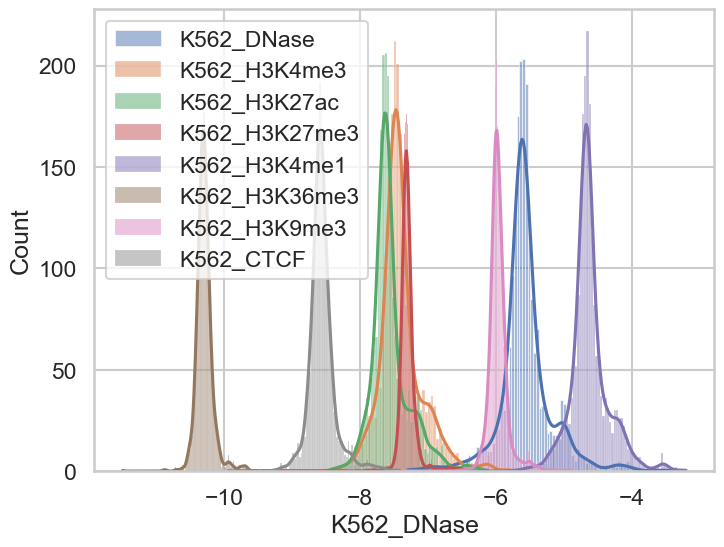

In [36]:
for col in MPRA_df.columns:
    if 'K562' in col:
        df = MPRA_df[MPRA_df['element'] == 'BCL11A']
        sns.histplot(df[col], label=col, kde=True)
plt.legend()

In [42]:
# normalize

for element in MPRA_df['element'].unique():
    condition = (MPRA_df['element'] == element)
    for i, cell_type in enumerate(cell_types):
        for j, assay in enumerate(assays):
            x = MPRA_df.loc[condition, f'{cell_type}_{assay}']
            x_mean = np.mean(x)
            x_std = np.std(x)
            x = (x - x_mean) / x_std
            MPRA_df.loc[condition, f'{cell_type}_{assay}'] = x

In [43]:
MPRA_df

,chr,pos,ref,alt,value,p-value,element,cell_type,seq,match_cell_type,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_H3K27me3,HEK293T_H3K4me1,HEK293T_H3K36me3,HeLa_DNase,HeLa_H3K4me3,HeLa_H3K27ac,HeLa_H3K27me3,HeLa_H3K4me1,HeLa_H3K36me3,HeLa_H3K9me3,HeLa_CTCF,HEK293T_H3K9me3,HEK293T_CTCF
0,2,60722075,C,-,-0.340,0.005,BCL11A,HEL 92.1.7,CTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGATG...,K562,1.332,1.350,1.293,-0.080,1.532,-0.412,-0.091,0.742,0.100,0.456,0.372,0.114,0.608,-0.546,1.081,0.411,-1.162,0.887,0.666,0.092,1.166,0.253,0.098,-0.497,-0.365,-0.493,-0.206,-1.263,0.198,-0.384,NaN,NaN
1,2,60722075,C,A,-0.050,0.389,BCL11A,HEL 92.1.7,ACTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-0.057,-0.093,-0.171,-0.202,-0.070,-0.213,-0.308,-0.189,0.138,0.148,0.069,-0.103,0.041,-0.223,-0.408,-0.059,-0.175,-0.005,0.035,-0.194,-0.141,-0.017,0.304,0.358,0.219,-0.153,0.226,-0.176,-0.388,-0.151,NaN,NaN
2,2,60722075,C,G,-0.130,0.137,BCL11A,HEL 92.1.7,GCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,0.008,-0.008,-0.160,-0.051,-0.009,-0.125,-0.346,-0.016,0.186,0.190,0.059,0.113,0.086,-0.054,-0.464,0.127,-0.091,0.091,0.108,-0.244,0.028,-0.106,0.138,0.325,0.004,0.035,0.147,-0.135,-0.466,0.067,NaN,NaN
3,2,60722075,C,T,-0.700,0.000,BCL11A,HEL 92.1.7,TCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-0.122,-0.250,-0.257,-0.189,-0.169,-0.241,-0.437,-0.261,0.060,-0.035,-0.048,-0.256,0.007,-0.220,-0.190,-0.143,-0.074,-0.256,-0.034,-0.043,-0.123,-0.389,0.048,-0.021,0.049,-0.068,0.111,-0.196,-0.348,-0.093,NaN,NaN
4,2,60722076,C,A,-0.080,0.004,BCL11A,HEL 92.1.7,CATAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-0.241,-0.333,-0.390,-0.432,-0.219,-0.497,-0.406,-0.596,-0.026,-0.078,-0.165,-0.406,-0.055,-0.384,-0.085,-0.480,-0.615,-0.487,-0.341,-0.463,-0.395,-0.482,-0.262,-0.407,-0.277,-0.179,-0.107,-0.515,-0.298,-0.974,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44638,7,156584296,G,T,0.100,0.000,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-1.604,-2.237,-2.706,-0.435,-1.755,-1.335,-1.629,-0.029,-0.666,-1.857,-1.850,-1.015,-1.179,-1.892,-0.517,0.052,-1.093,-1.249,-1.946,0.423,-0.606,0.081,-0.288,-1.239,-1.451,0.301,-0.646,-1.538,-0.760,0.117,NaN,NaN
44639,7,156584297,C,-,0.040,0.112,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-0.393,-0.710,0.100,0.117,-0.593,0.752,1.067,0.574,-0.345,-1.422,-0.695,0.252,-1.443,-0.137,1.992,0.464,1.147,-0.961,-1.328,-0.224,-0.988,0.134,-0.257,-1.010,-0.460,0.453,-0.852,1.166,1.965,0.598,NaN,NaN
44640,7,156584297,C,A,-0.170,0.334,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-1.248,-1.440,-2.055,-1.017,-1.673,-1.697,-1.796,-0.005,-0.926,-1.115,-1.613,-0.737,-0.958,-1.709,-0.809,0.006,-0.918,-1.349,-1.383,-0.100,-0.792,-0.734,-1.203,-1.483,-1.891,-0.065,-1.570,-1.724,-0.719,-0.034,NaN,NaN
44641,7,156584297,C,G,0.060,0.091,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-1.002,-1.041,-1.859,-0.046,-1.494,-1.190,-0.593,0.222,-0.555,-0.684,-1.345,0.300,-0.499,-0.991,-1.259,0.209,-0.388,-0.849,-1.328,0.442,-0.297,0.282,-0.968,-0.989,-1.731,0.685,-1.340,-0.867,-0.281,0.116,NaN,NaN


In [44]:
MPRA_df.to_csv('../data/CAGI5_MPRA/CAGI5_MPRA_Sei_feature_norm.csv', index=False)

In [45]:
MPRA_df = pd.read_csv('../data/CAGI5_MPRA/CAGI5_MPRA_Sei_feature_norm.csv')
MPRA_df

/tmp/ipykernel_54568/647625667.py:1: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  MPRA_df = pd.read_csv('../data/CAGI5_MPRA/CAGI5_MPRA_Sei_feature_norm.csv')


,chr,pos,ref,alt,value,p-value,element,cell_type,seq,match_cell_type,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,HEK293T_DNase,HEK293T_H3K4me3,HEK293T_H3K27ac,HEK293T_H3K27me3,HEK293T_H3K4me1,HEK293T_H3K36me3,HeLa_DNase,HeLa_H3K4me3,HeLa_H3K27ac,HeLa_H3K27me3,HeLa_H3K4me1,HeLa_H3K36me3,HeLa_H3K9me3,HeLa_CTCF,HEK293T_H3K9me3,HEK293T_CTCF
0,2,60722075,C,-,-0.340,0.005,BCL11A,HEL 92.1.7,CTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGATG...,K562,1.332,1.350,1.293,-0.080,1.532,-0.412,-0.091,0.742,0.100,0.456,0.372,0.114,0.608,-0.546,1.081,0.411,-1.162,0.887,0.666,0.092,1.166,0.253,0.098,-0.497,-0.365,-0.493,-0.206,-1.263,0.198,-0.384,NaN,NaN
1,2,60722075,C,A,-0.050,0.389,BCL11A,HEL 92.1.7,ACTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-0.057,-0.093,-0.171,-0.202,-0.070,-0.213,-0.308,-0.189,0.138,0.148,0.069,-0.103,0.041,-0.223,-0.408,-0.059,-0.175,-0.005,0.035,-0.194,-0.141,-0.017,0.304,0.358,0.219,-0.153,0.226,-0.176,-0.388,-0.151,NaN,NaN
2,2,60722075,C,G,-0.130,0.137,BCL11A,HEL 92.1.7,GCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,0.008,-0.008,-0.160,-0.051,-0.009,-0.125,-0.346,-0.016,0.186,0.190,0.059,0.113,0.086,-0.054,-0.464,0.127,-0.091,0.091,0.108,-0.244,0.028,-0.106,0.138,0.325,0.004,0.035,0.147,-0.135,-0.466,0.067,NaN,NaN
3,2,60722075,C,T,-0.700,0.000,BCL11A,HEL 92.1.7,TCTAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-0.122,-0.250,-0.257,-0.189,-0.169,-0.241,-0.437,-0.261,0.060,-0.035,-0.048,-0.256,0.007,-0.220,-0.190,-0.143,-0.074,-0.256,-0.034,-0.043,-0.123,-0.389,0.048,-0.021,0.049,-0.068,0.111,-0.196,-0.348,-0.093,NaN,NaN
4,2,60722076,C,A,-0.080,0.004,BCL11A,HEL 92.1.7,CATAACACAGTAGCTGGTACCTGATAGGTGCCTATATGTGATGGAT...,K562,-0.241,-0.333,-0.390,-0.432,-0.219,-0.497,-0.406,-0.596,-0.026,-0.078,-0.165,-0.406,-0.055,-0.384,-0.085,-0.480,-0.615,-0.487,-0.341,-0.463,-0.395,-0.482,-0.262,-0.407,-0.277,-0.179,-0.107,-0.515,-0.298,-0.974,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44638,7,156584296,G,T,0.100,0.000,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-1.604,-2.237,-2.706,-0.435,-1.755,-1.335,-1.629,-0.029,-0.666,-1.857,-1.850,-1.015,-1.179,-1.892,-0.517,0.052,-1.093,-1.249,-1.946,0.423,-0.606,0.081,-0.288,-1.239,-1.451,0.301,-0.646,-1.538,-0.760,0.117,NaN,NaN
44639,7,156584297,C,-,0.040,0.112,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-0.393,-0.710,0.100,0.117,-0.593,0.752,1.067,0.574,-0.345,-1.422,-0.695,0.252,-1.443,-0.137,1.992,0.464,1.147,-0.961,-1.328,-0.224,-0.988,0.134,-0.257,-1.010,-0.460,0.453,-0.852,1.166,1.965,0.598,NaN,NaN
44640,7,156584297,C,A,-0.170,0.334,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-1.248,-1.440,-2.055,-1.017,-1.673,-1.697,-1.796,-0.005,-0.926,-1.115,-1.613,-0.737,-0.958,-1.709,-0.809,0.006,-0.918,-1.349,-1.383,-0.100,-0.792,-0.734,-1.203,-1.483,-1.891,-0.065,-1.570,-1.724,-0.719,-0.034,NaN,NaN
44641,7,156584297,C,G,0.060,0.091,ZRSh-13h2,NIH/3T3 (with HOXD13/ HOXD13+HAND2),TGAGATATGGCTTCATTTTCTGTAATAAACACTAAGATCAAAACAT...,NaN,-1.002,-1.041,-1.859,-0.046,-1.494,-1.190,-0.593,0.222,-0.555,-0.684,-1.345,0.300,-0.499,-0.991,-1.259,0.209,-0.388,-0.849,-1.328,0.442,-0.297,0.282,-0.968,-0.989,-1.731,0.685,-1.340,-0.867,-0.281,0.116,NaN,NaN


In [46]:
for i, row in MPRA_df.iterrows():
    if len(MPRA_df.loc[i, 'seq']) > 600:
        MPRA_df.loc[i, 'seq'] = MPRA_df.loc[i, 'seq'][:600]

In [47]:
MPRA_df.to_csv('../data/CAGI5_MPRA/CAGI5_MPRA_Sei_feature_norm.csv', index=False)